# Inclination Change

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as  plt
import matplotlib.dates as mdates
import mplcursors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mticker

from models import atmosDensity, Cubesat
from maneuvers import Maneuvers
from coordinates import cart2kep
from constants import constants
import helpers

In [2]:
%matplotlib notebook

In [3]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: inline;
}
</style>

In [4]:
#----- INITIAL CONDITIONS -----
# Explicit conditions
rp = constants.Re+50000e3
ra = constants.Re+50001e3
Omega = 30*np.pi/180
i = 2*np.pi/180#65.1*np.pi/180
omega = 30*np.pi/180
M = 332*np.pi/180
#-------------------
# Derived conditions
e = (ra-rp)/(ra+rp)
a = (ra+rp)/2
#--------------------
# Final conditions
coe = [a,e,i,omega,Omega,M]
date = datetime.now()
#coe,date = helpers.parseTle("suchai0.tle")

#----- SPACECRAFT DEFINITIONS -----
satellite = Cubesat()

# ---- MANEUVERING ------
maneuvers = Maneuvers(coe,satellite,date)
#maneuvers.addPerturbation("atmosphere")
maneuvers.propagate2(60*60*24*1)

#maneuvers.addPerturbation("J2")
#maneuvers.addPerturbation("moon_gravity")
#maneuvers.addPerturbation("sun_gravity")
#maneuvers.addPerturbation("solar_pressure")
maneuvers.addPerturbation("thrust")
%time maneuvers.propagate2(60*60*18)
maneuvers.removePerturbation("thrust")
maneuvers.propagate2(60*60*24*1)

Propagating...from day  0.0  to  1.0
Day:0.0	Height: 50000.05852522624 km	Mass: 1.0
Day:8.483006497467494e-08	Height: 50000.058525145134 km	Mass: 1.0
Day:1.6966012994934989e-07	Height: 50000.058525064036 km	Mass: 1.0
Day:0.0008484703098766987	Height: 50000.0577166983 km	Mass: 1.0
Day:0.0008484703098766987	Height: 50000.05771669828 km	Mass: 1.0
Perc:0.0
Perc:10.0
Perc:20.0
Perc:30.0
Perc:40.0
Perc:50.0
Perc:60.0
Perc:70.0
Perc:80.0
Perc:90.0
Propagating...from day  1.0  to  1.75
Day:1.0	Height: 50000.95183676564 km	Mass: 1.0
Day:1.0001041779732922	Height: 50000.95174587915 km	Mass: 0.9998725131878946
Day:1.0001041779732922	Height: 50000.951745879145 km	Mass: 0.9998725131878946
Day:1.0002083559465846	Height: 50000.9516549113 km	Mass: 0.9997450263757892
Day:1.0002083559465846	Height: 50000.95165491132 km	Mass: 0.9997450263757892
Perc:0.0
Perc:10.0
Perc:20.0
Perc:30.0
Perc:40.0
Perc:50.0
Perc:60.0
Perc:70.0
Perc:80.0
Perc:90.0
Wall time: 125 ms
Propagating...from day  1.75  to  2.75
Perc:0

<IPython.core.display.Javascript object>


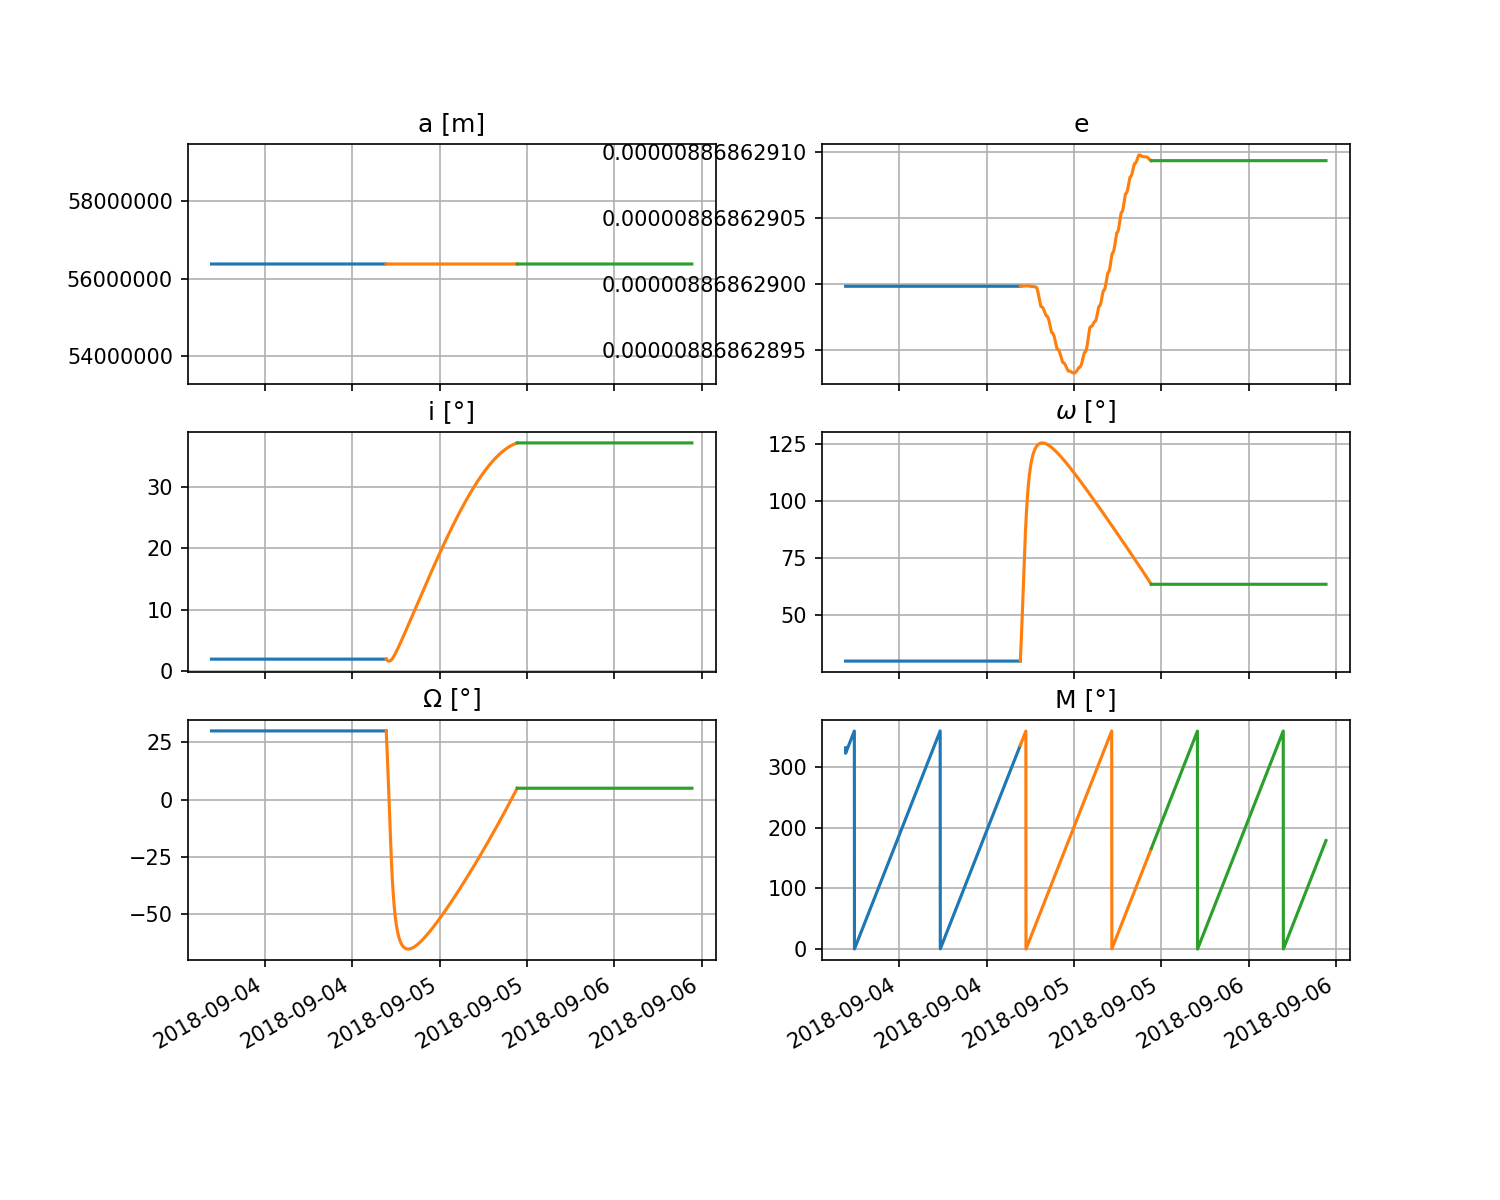

In [11]:
# PLOTTING CLASSICAL ORBITAL ELEMENTS
titles = ["a","e","i","$\omega$","$\Omega$","M"]
ylabels = ["[m]", "", "[°]", "[°]", "[°]", "[°]"]
fig, axes = plt.subplots(3,2,figsize=(10,8))
for i in range(0,6):
    for j in range(0,len(maneuvers.history.maneuverIdxs)-1):
        maneuverSlice = slice(maneuvers.history.maneuverIdxs[j],maneuvers.history.maneuverIdxs[j+1])
        if i in [2,3,4,5]:
            axes[int((i-i%2)/2),i%2].plot(maneuvers.history.datetime[maneuverSlice],maneuvers.history.coe[maneuverSlice,i]*180/np.pi)
        else:
            axes[int((i-i%2)/2),i%2].plot(maneuvers.history.datetime[maneuverSlice],maneuvers.history.coe[maneuverSlice,i])
        axes[int((i-i%2)/2),i%2].set_title(titles[i]+" "+ylabels[i])
        
        fig.autofmt_xdate()
        axes[int((i-i%2)/2),i%2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        axes[int((i-i%2)/2),i%2].yaxis.get_major_formatter().set_scientific(False)
        axes[int((i-i%2)/2),i%2].yaxis.get_major_formatter().set_useOffset(False)
        axes[int((i-i%2)/2),i%2].grid(b=True)

<IPython.core.display.Javascript object>


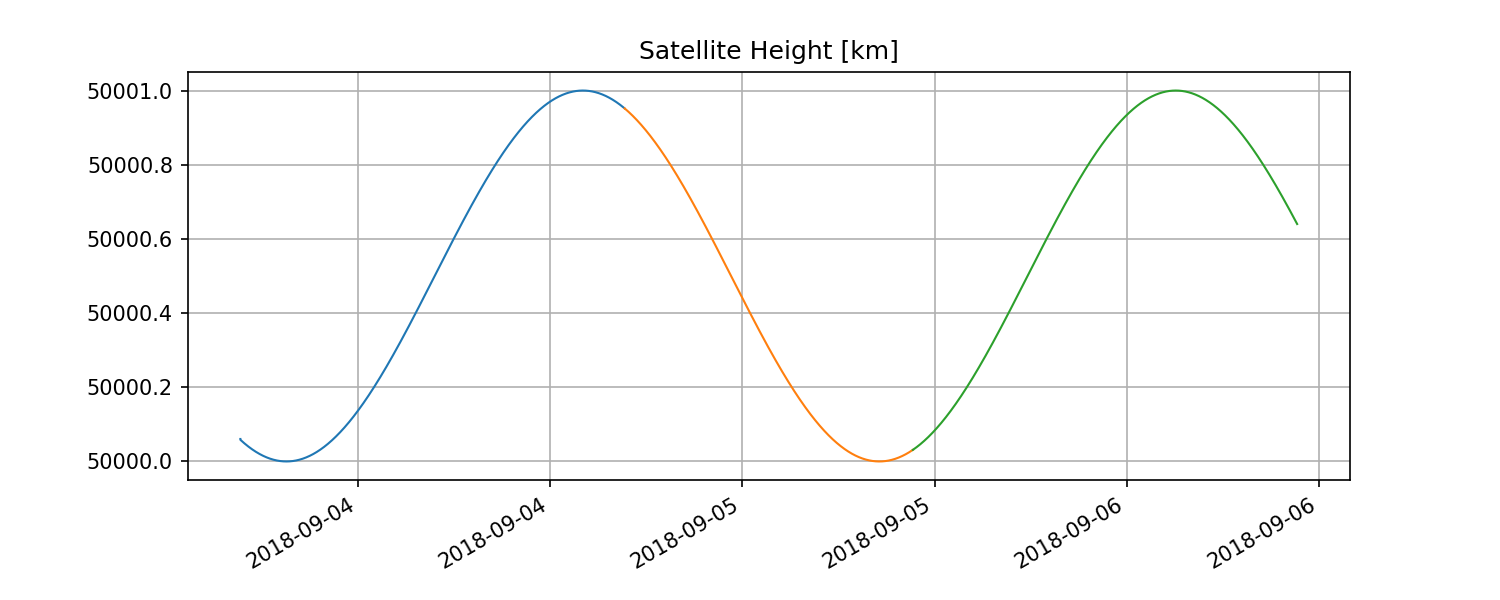

<IPython.core.display.Javascript object>


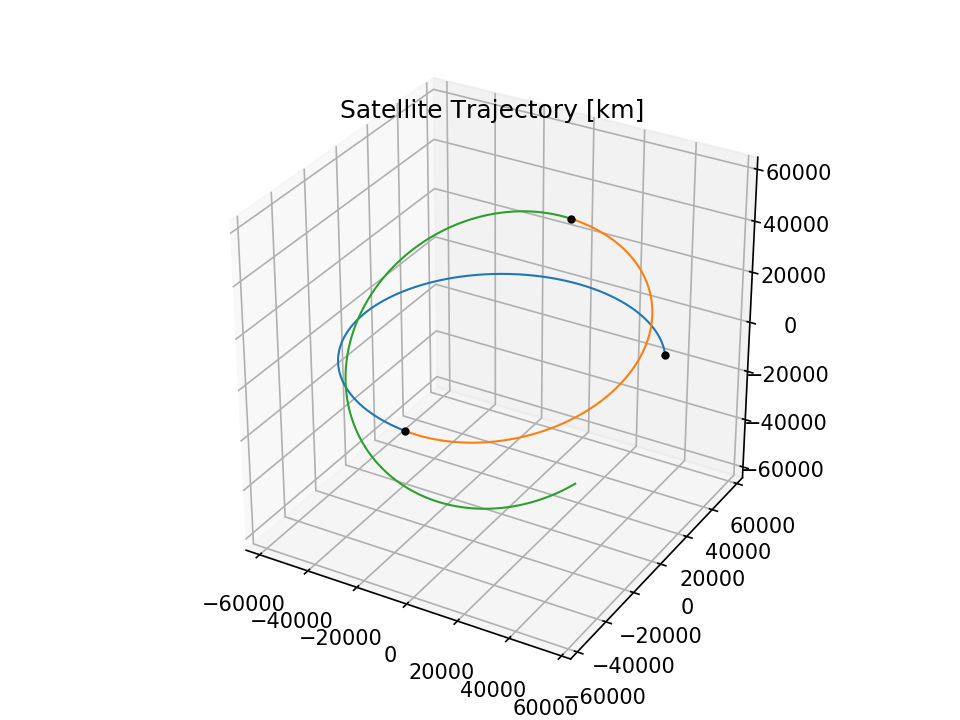

<IPython.core.display.Javascript object>


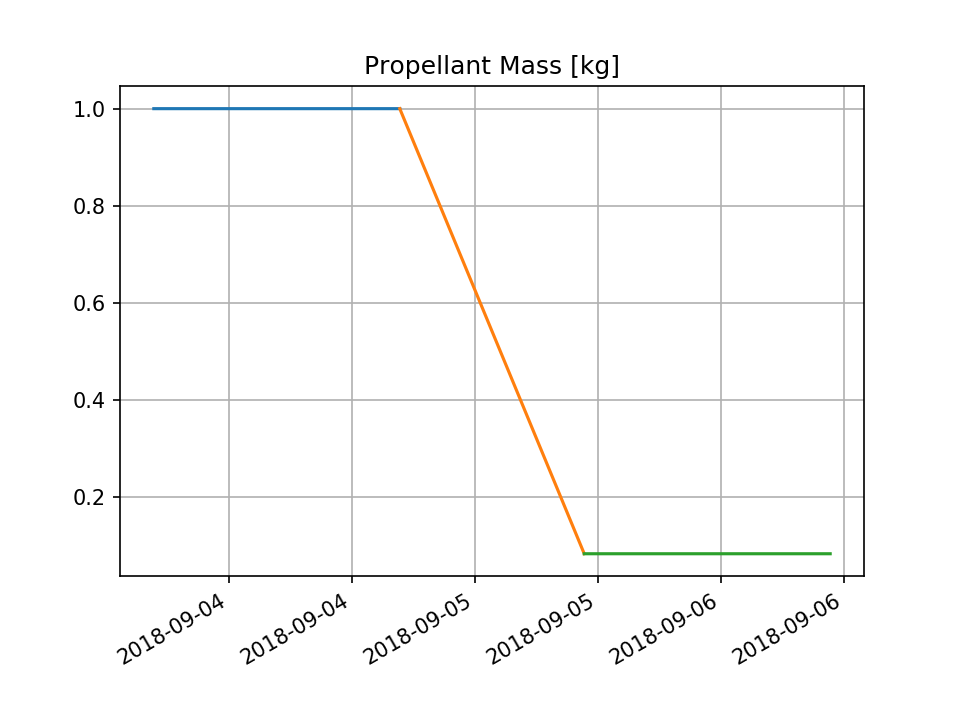

In [17]:
#Plot Height
fig, ax = plt.subplots(figsize=(10,4))
for i in range(0,len(maneuvers.history.maneuverIdxs)-1):
    maneuverSlice = slice(maneuvers.history.maneuverIdxs[i],maneuvers.history.maneuverIdxs[i+1])
    #plt.plot(maneuvers.history.t[maneuvers.history.maneuverIdxs[i]:maneuvers.history.maneuverIdxs[i+1]]/60/60/24,
    #        (np.linalg.norm(maneuvers.history.r[maneuvers.history.maneuverIdxs[i]:maneuvers.history.maneuverIdxs[i+1],:],axis=1)-constants.Re)/1000,linewidth=1)
    ax.plot(maneuvers.history.datetime[maneuverSlice],
            (np.linalg.norm(maneuvers.history.r[maneuverSlice,:],axis=1)-constants.Re)/1000,linewidth=1)

ax.set_title("Satellite Height [km]")
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.grid()

#Plot 3D Trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
markers = np.zeros([len(maneuvers.history.maneuverIdxs)-1,3])

for i in range(0,len(maneuvers.history.maneuverIdxs)-1):
    maneuverSlice = slice(maneuvers.history.maneuverIdxs[i],maneuvers.history.maneuverIdxs[i+1])
    ax.plot3D(maneuvers.history.r[maneuverSlice,0]/1000,
              maneuvers.history.r[maneuverSlice,1]/1000,
              maneuvers.history.r[maneuverSlice,2]/1000,linewidth=1)
    markers[i,:]= maneuvers.history.r[maneuvers.history.maneuverIdxs[i],:]/1000
ax.plot3D(markers[:,0],markers[:,1],markers[:,2],"k.")
helpers.set_axes_equal(ax)
ax.set_aspect("equal")
scale_x = 1.2
scale_y = 1.2
scale_z = 1.2
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([scale_x, scale_y, scale_z, 1]))
ax.set_title("Satellite Trajectory [km]")

#Plot Propellant Usage
fig2, ax2 = plt.subplots()
for i in range(0,len(maneuvers.history.maneuverIdxs)-1):
    maneuverSlice = slice(maneuvers.history.maneuverIdxs[i],maneuvers.history.maneuverIdxs[i+1])
    ax2.plot(maneuvers.history.datetime[maneuverSlice],maneuvers.history.propMass[maneuverSlice])
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.grid()
ax2.set_title("Propellant Mass [kg]");
fig2.autofmt_xdate()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))